In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from xfoil import XFoil
from xfoil.model import Airfoil

from lib.utils import load_pkl, save_pkl
from lib.preprocess_modules import *
from lib.predict_modules import *
from config import *

from nets.nn import *

In [2]:
model = light_param_net(3072)
model.load_weights(str(Path('./weights', '2020-12-26 10-56.h5')))

Light parametrization net output shape: (None, 512, 512, 1)


In [3]:
fname = "mh32.dat" 

In [4]:
foil_array, alfas, Re = prepare_foil_to_predict(fname, 6)
X = foil_array.reshape(foil_array.shape[0]*foil_array.shape[1]*foil_array.shape[2])
re_dict = dict(zip(Re, range(len(Re))))
print("Available Re's:", Re)

Prepare mh32.dat...
mh32.dat data prepared for prediction.
Available Re's: [ 40000  50666  61333  72000  82666  93333 104000 114666 125333 136000
 146666 157333 168000 178666 189333 200000]


In [5]:
desired_Re = 168000

re_pos = re_dict[desired_Re]
Cy = foil_array[0, re_pos, :]; Cx = foil_array[1, re_pos, :]; Cm = foil_array[2, re_pos, :]; Cp = foil_array[3, re_pos, :]
d = foil_array[4,0,0] ; S = foil_array[5,0,0]

Foil mh32.dat, Re=168000, S=0.0870, d=0.0521


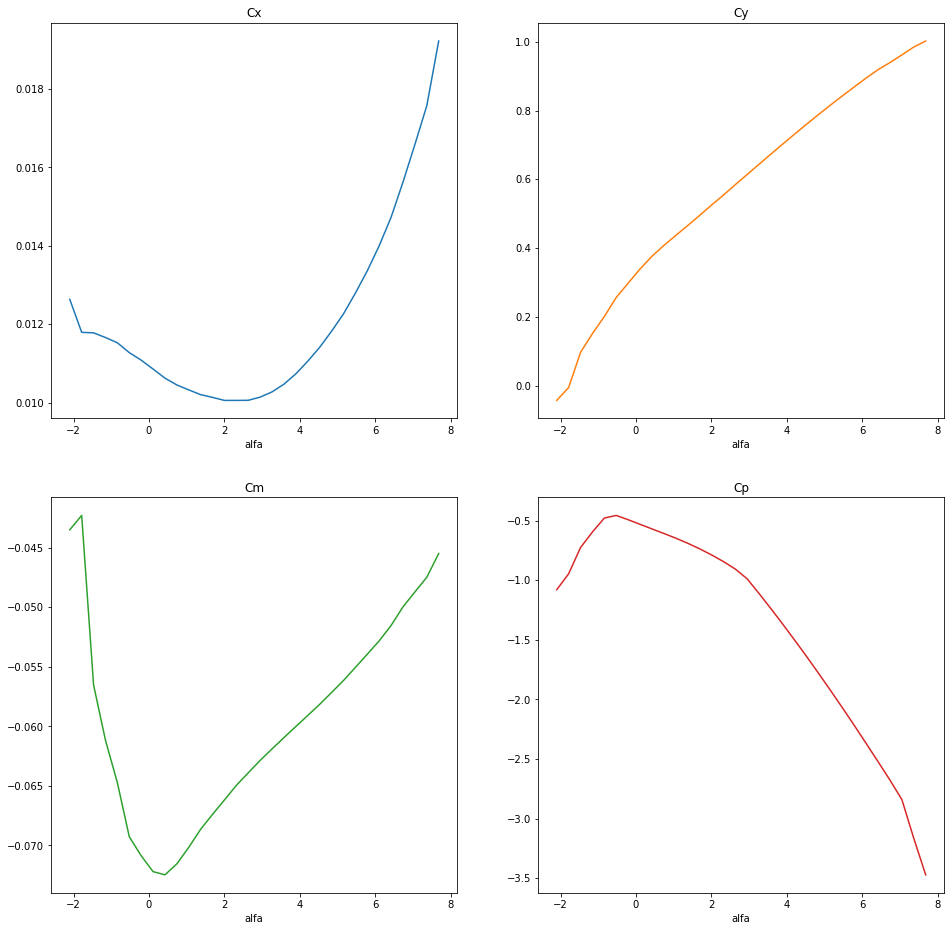

In [6]:
print("Foil %s, Re=%i, S=%2.6s, d=%2.6s" % (fname, desired_Re, S, d))
fig, axs = plt.subplots(2, 2, figsize=(16,16))
fig.dpi
axs[0, 0].plot(alfas, Cx)
axs[0, 0].set_title('Cx')
axs[0, 1].plot(alfas, Cy, 'tab:orange')
axs[0, 1].set_title('Cy')
axs[1, 0].plot(alfas, Cm, 'tab:green')
axs[1, 0].set_title('Cm')
axs[1, 1].plot(alfas, Cp, 'tab:red')
axs[1, 1].set_title('Cp')

for ax in axs.flat:
    ax.set(xlabel='alfa', ylabel='')

# Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer();

In [7]:
y = np.round(model.predict(X[None,:]))[0, :, :, 0]
y.shape

(512, 512)

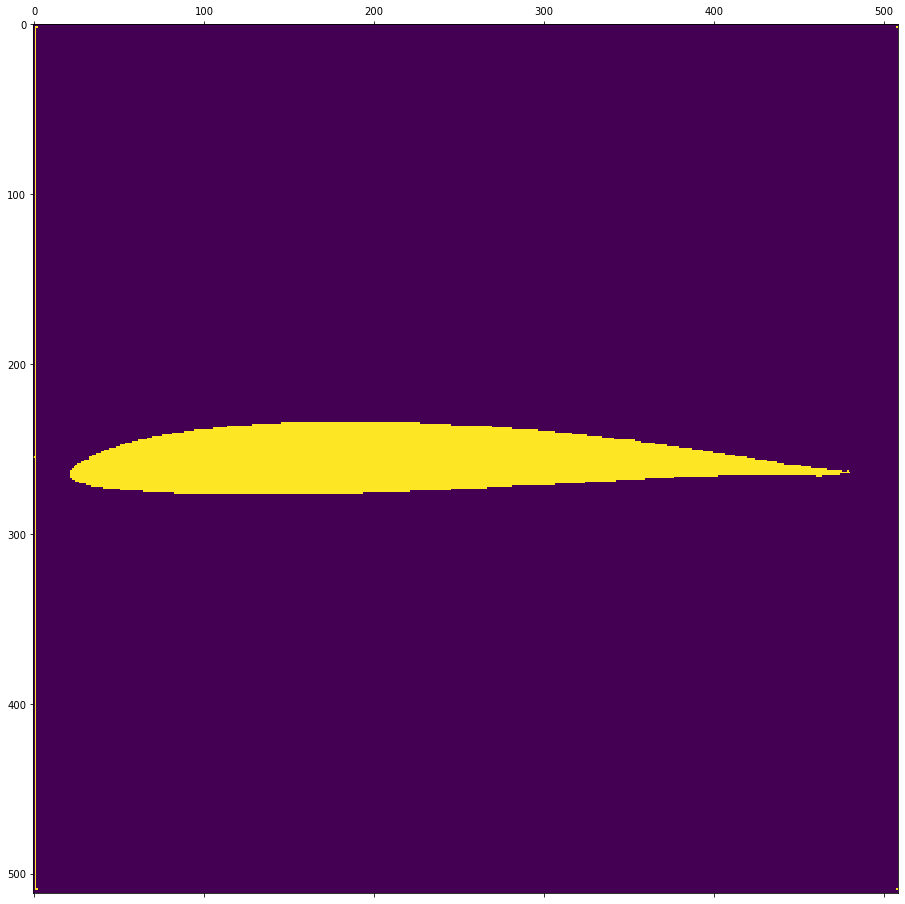

In [10]:
plt.figure(figsize=(16,16))
plt.matshow(y,0)

In [9]:
# ищем координаты

# сначала определим координаты начала и конца оси профиля

for x_nose in range(y.shape[1]):
    res = find_first_and_last_1_position(y[:, x_nose])
    if res!=-1:
        y_nose_top, y_nose_bot = res
        break
        
for x_tail in range(y.shape[1]-1,0,-1):
    res = find_first_and_last_1_position(y[:, x_tail])
    if res!=-1:
        y_tail_top, y_tail_bot = res
        break

if y_nose_top!=y_nose_bot: # ставим точку в середине носика, пригодится для красивой аппроксимации
    y_nose = int(np.average((y_nose_top, y_nose_bot)))
    y[y_nose,x_nose-1]=1
    x_nose-=1

if y_tail_top!=y_tail_bot: # а на хвостике не ставим и вообще хз чё делаем - к Димке
    pass
#     y_tail = int(np.average((y_tail_top, y_tail_bot)))
# else:
#     y_tail = y_tail_top
    
print(x_nose, y_nose, x_tail)

y=y[:, x_nose:x_tail+1]

foil_x_top = (np.arange(y.shape[1])).tolist(); foil_x_top.reverse()
foil_x_bot = foil_x_top.copy() #foil_x[:-1]; x2.reverse() ; foil_x.extend(x2)
foil_y_top=[]
foil_y_bot=[]
for x in foil_x_top:
    if find_first_and_last_1_position(y[:, x])==-1: raise Exception
    y_t, y_b = find_first_and_last_1_position(y[:, x])
    foil_y_top.append(y_nose - y_t)
    foil_y_bot.append(y_nose - y_b)
foil_x_bot = foil_x_bot[:-1]
foil_x_bot.reverse()
foil_y_bot = foil_y_bot[:-1]
foil_y_bot.reverse()
foil_x_top.extend(foil_x_bot)
foil_y_top.extend(foil_y_bot)
foil_x = np.array(foil_x_top)/(y.shape[1]-1)
foil_y = np.array(foil_y_top)/(y.shape[1]-1)
foil_x.shape, foil_y.shape

1 255 509


Exception: 

In [93]:
src_x, src_y = read_airfoil_dat_file(Path(foils_dat_path,'mh32.dat'))

([<matplotlib.lines.Line2D at 0x232731aa748>],
 [<matplotlib.lines.Line2D at 0x23277a07608>])

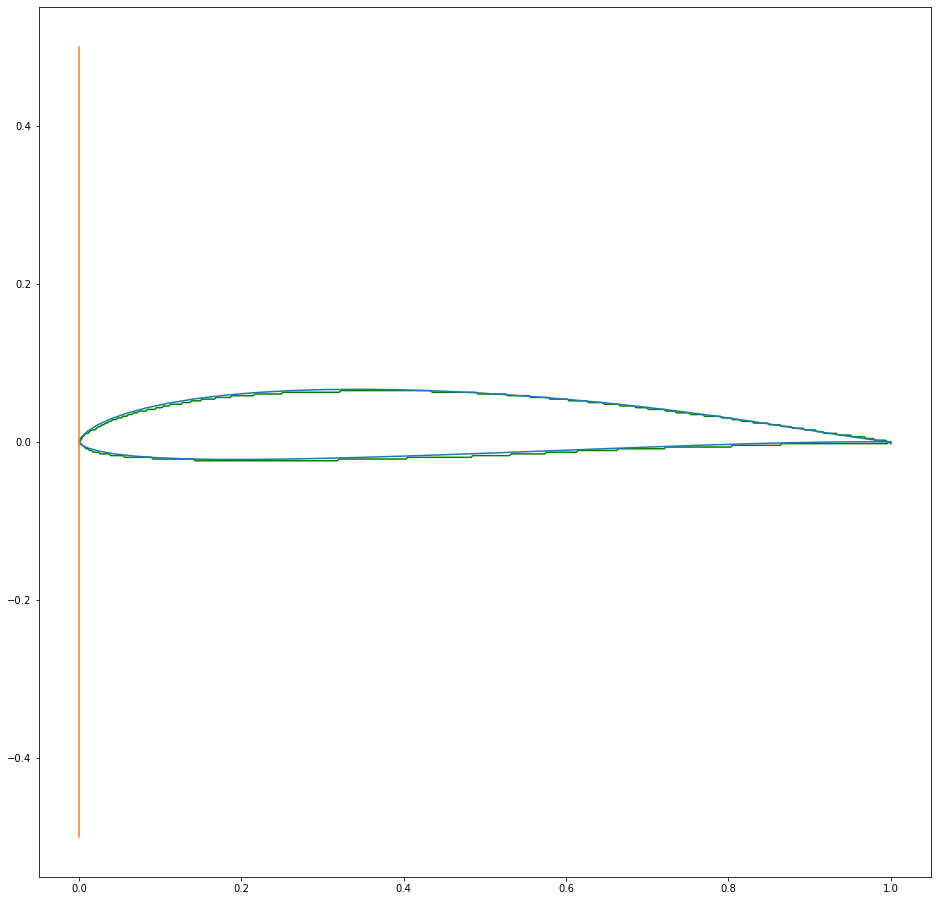

In [98]:
# f_x, f_y = interpolate_airfoil(foil_x, foil_y, 256)
f_x, f_y = foil_x, foil_y
plt.figure(figsize=(16,16))
plt.plot(f_x, f_y, 'green'), plt.plot(src_x, src_y), plt.plot([0,0],[-0.5,0.5])

In [110]:
src_x

array([1.0000000e+00, 9.9671850e-01, 9.8706463e-01, 9.7145561e-01,
       9.5035123e-01, 9.2424036e-01, 8.9362390e-01, 8.5900629e-01,
       8.2089086e-01, 7.7977368e-01, 7.3609426e-01, 6.9023068e-01,
       6.4259066e-01, 5.9361615e-01, 5.4382705e-01, 4.9381832e-01,
       4.4411124e-01, 3.9514537e-01, 3.4741929e-01, 3.0140493e-01,
       2.5746856e-01, 2.1602684e-01, 1.7749047e-01, 1.4216302e-01,
       1.1032399e-01, 8.2219630e-02, 5.8053310e-02, 3.7962690e-02,
       2.2057040e-02, 1.0377360e-02, 3.0068100e-03, 1.8491400e-03,
       8.1352000e-04, 1.8114000e-04, 4.8300000e-06, 8.2180000e-05,
       4.8790000e-04, 1.2055000e-03, 2.7369000e-03, 4.7652900e-03,
       1.1929810e-02, 2.6042400e-02, 4.5205000e-02, 6.9259660e-02,
       9.8018490e-02, 1.3124461e-01, 1.6864181e-01, 2.0985766e-01,
       2.5447576e-01, 3.0202197e-01, 3.5197672e-01, 4.0378144e-01,
       4.5685259e-01, 5.1058787e-01, 5.6437178e-01, 6.1758180e-01,
       6.6959046e-01, 7.1977196e-01, 7.6751419e-01, 8.1222445e

In [111]:
f_x

array([1.        , 0.9978355 , 0.995671  , 0.99350649, 0.99134199,
       0.98917749, 0.98701299, 0.98484848, 0.98268398, 0.98051948,
       0.97835498, 0.97619048, 0.97402597, 0.97186147, 0.96969697,
       0.96753247, 0.96536797, 0.96320346, 0.96103896, 0.95887446,
       0.95670996, 0.95454545, 0.95238095, 0.95021645, 0.94805195,
       0.94588745, 0.94372294, 0.94155844, 0.93939394, 0.93722944,
       0.93506494, 0.93290043, 0.93073593, 0.92857143, 0.92640693,
       0.92424242, 0.92207792, 0.91991342, 0.91774892, 0.91558442,
       0.91341991, 0.91125541, 0.90909091, 0.90692641, 0.9047619 ,
       0.9025974 , 0.9004329 , 0.8982684 , 0.8961039 , 0.89393939,
       0.89177489, 0.88961039, 0.88744589, 0.88528139, 0.88311688,
       0.88095238, 0.87878788, 0.87662338, 0.87445887, 0.87229437,
       0.87012987, 0.86796537, 0.86580087, 0.86363636, 0.86147186,
       0.85930736, 0.85714286, 0.85497835, 0.85281385, 0.85064935,
       0.84848485, 0.84632035, 0.84415584, 0.84199134, 0.83982

In [112]:
y.dtype

dtype('float32')